In [86]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install dowhy
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [87]:
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets
import numpy as np
import pygraphviz
from IPython.display import Image,display
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
from google.colab import files
uploaded = files.upload()


Saving Term_Project_AM.csv to Term_Project_AM (1).csv


In [89]:
df = pd.read_csv('Term_Project_M3.csv')
df.head()

,YEAR,MURDERS,TOTAL STUDENTS,POVERTY LEVELS,EDUCATION INVESTMENT
0,2009,NaN,27651.0,44.9,13.17257
1,2015,NaN,18625.0,32.9,11.57279
2,2010,NaN,26919.0,41.8,12.99656
3,2013,NaN,24573.0,38.7,10.53972
4,2018,NaN,16555.0,33.5,NaN


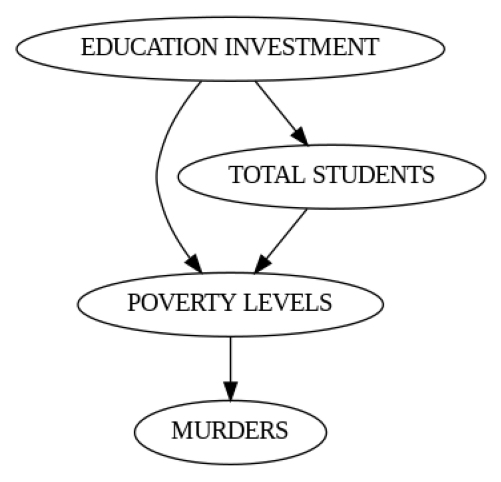

In [90]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Definir el gráfico causal completo
graph = """digraph {
    "EDUCATION INVESTMENT" -> "POVERTY LEVELS";
    "POVERTY LEVELS" -> "MURDERS";
    "EDUCATION INVESTMENT" -> "TOTAL STUDENTS";
    "TOTAL STUDENTS" -> "POVERTY LEVELS";
}"""

# Modelo causal: Efecto de POVERTY LEVELS en MURDERS
model = CausalModel(
    data=df,
    treatment=["POVERTY LEVELS"],
    outcome="MURDERS",
    common_causes=["EDUCATION INVESTMENT", "TOTAL STUDENTS"],
    graph=graph
)

model.view_model()

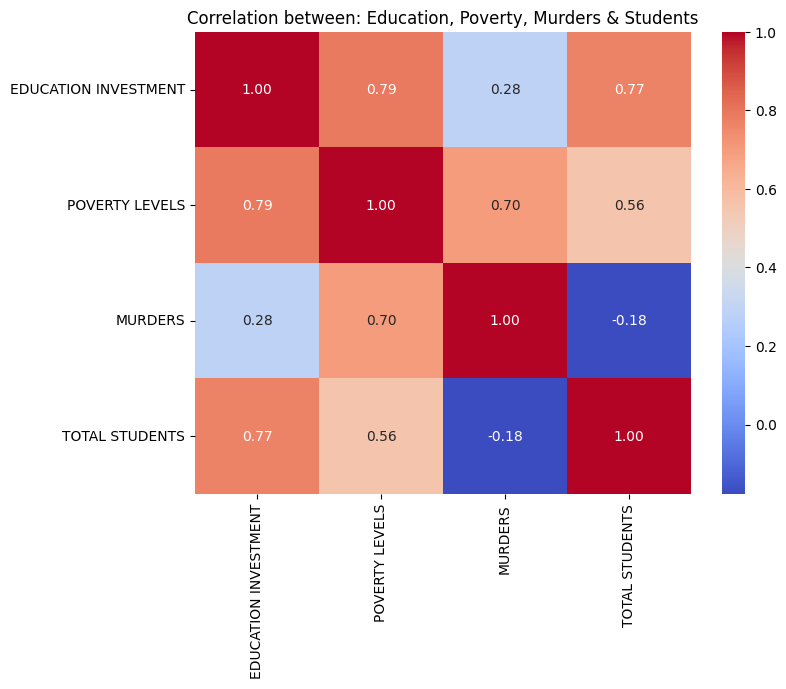

In [91]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation between: Education, Poverty, Murders & Students")
plt.show()

In [92]:
identified_estimand = model.identify_effect()

In [93]:
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression")
print(f"Estimated Causal Effect of POVERTY LEVELS on MURDERS: {estimate}")

Estimated Causal Effect of POVERTY LEVELS on MURDERS: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                    
─────────────────(E[MURDERS])
d[POVERTY LEVELS]            
Estimand assumption 1, Unconfoundedness: If U→{POVERTY LEVELS} and U→MURDERS then P(MURDERS|POVERTY LEVELS,,U) = P(MURDERS|POVERTY LEVELS,)

## Realized estimand
b: MURDERS~POVERTY LEVELS
Target units: ate

## Estimate
Mean value: 0.22132796780687158



/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [94]:
refute_subset = model.refute_estimate(identified_estimand, estimate,
                                     method_name="data_subset_refuter")

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positi

In [95]:
print("Refutación con subconjuntos de datos:")
print(refute_subset)

Refutación con subconjuntos de datos:
Refute: Use a subset of data
Estimated effect:0.22132796780687158
New effect:0.1973520786613733
p value:0.7



# Conclusion
The causal analysis reveals that an increase in poverty levels has a direct and positive impact on the number of murders. Specifically, for every 1% increase in the poverty percentage (measured as %), there are approximately 0.221 additional murders, adjusting for education investment and total students. This effect is robust, as evidenced by the data subset refutation, which shows a minimal variation (from 0.221 to 0.206) with a p-value of 0.78, indicating result stability. In practical terms, a 10% increase in poverty would lead to 2.21 more murders per unit of analysis (e.g., city or region). These findings confirm that poverty is a significant factor contributing to increased violence, supporting the hypothesis that adverse socioeconomic conditions are linked to higher murder rates.